# RuBERT news evaluator

In [6]:
# pip install transformers sentencepiece
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
model.cuda()  # uncomment it if you have a GPU

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29564, 312, padding_idx=0)
    (position_embeddings): Embedding(512, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [7]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
from mpl_toolkits import mplot3d

from sklearn.decomposition import PCA
from scipy import spatial

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

plt.rcParams['figure.figsize'] = [15, 15]
plt.style.use('dark_background')

## Import news

In [8]:
news = ["lenta_news.csv", "fontanka_news.csv"]

# CHANGE 0 TO 1 TO TOGGLE NEWS SOURCE
num_src = 0

raw_news = pd.read_csv(f"./{news[num_src]}", sep="\t", on_bad_lines="skip")

In [9]:
print(raw_news.shape)
raw_news.head()

(7629, 2)


,date,title
0,2020-01-01,В России изменились правила регистрации новых ...
1,2020-01-01,В России ввели электронные трудовые книжки
2,2020-01-01,В России подорожают автомобили
3,2020-01-01,В российском городе сожгли символ года за 670 ...
4,2020-01-01,В Москве и Петербурге изменились правила парко...


## Make dates date objects

In [10]:
datify = lambda x: date(int(x[0:4]), int(x[5:7]), int(x[8:10]))

start_d, end_d = datify(min(raw_news['date'])), datify(max(raw_news['date']))
delta_d = end_d - start_d
num_days = delta_d.days

print(f"From {start_d} to {end_d}")
print(f"Number of days: {num_days}")

From 2020-01-01 to 2020-09-30
Number of days: 273


## Make dates lag differences from 01.01.2020

In [11]:
deltify = lambda x: (datify(x) - start_d).days

raw_news['date'] = raw_news['date'].apply(deltify)

In [12]:
raw_news.head()

,date,title
0,0,В России изменились правила регистрации новых ...
1,0,В России ввели электронные трудовые книжки
2,0,В России подорожают автомобили
3,0,В российском городе сожгли символ года за 670 ...
4,0,В Москве и Петербурге изменились правила парко...


In [13]:
raw_news.tail()

,date,title
7624,273,Шесть мусорных полигонов закроют в Подмосковье...
7625,273,Песчаная буря обрушилась на российские регионы...
7626,273,Коммунисты осудили изнасилованную российскую п...
7627,273,Петербуржцев перестанут пускать в транспорт бе...
7628,273,Дегтярев посетил Амурск и призвал крупный бизн...


## Embed by BERT

In [14]:
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [15]:
news_num = raw_news.shape[0]
length_sent = embed_bert_cls("АБОБА", model, tokenizer).shape[0]
print(f"Number of news: {news_num}")
print(f"Length of embedding: {length_sent}")

Number of news: 7629
Length of embedding: 312


In [16]:
embedder = lambda x: embed_bert_cls(x, model, tokenizer)

embed_np = np.zeros((news_num, length_sent))

for i in range(len(raw_news)):
    res = embedder(raw_news['title'][i])
    print("\r", f"i: {i}", end="")
    for j in range(length_sent): 
        embed_np[i][j] = res[j]

 i: 7628

In [17]:
#embed_np = embed_np[:, np.any(embed_np, axis=0)]
cut_length = embed_np.shape[1]
print(f"Shape of stripped embedding: {embed_np.shape}")

Shape of stripped embedding: (7629, 312)


## Plot to see scatter

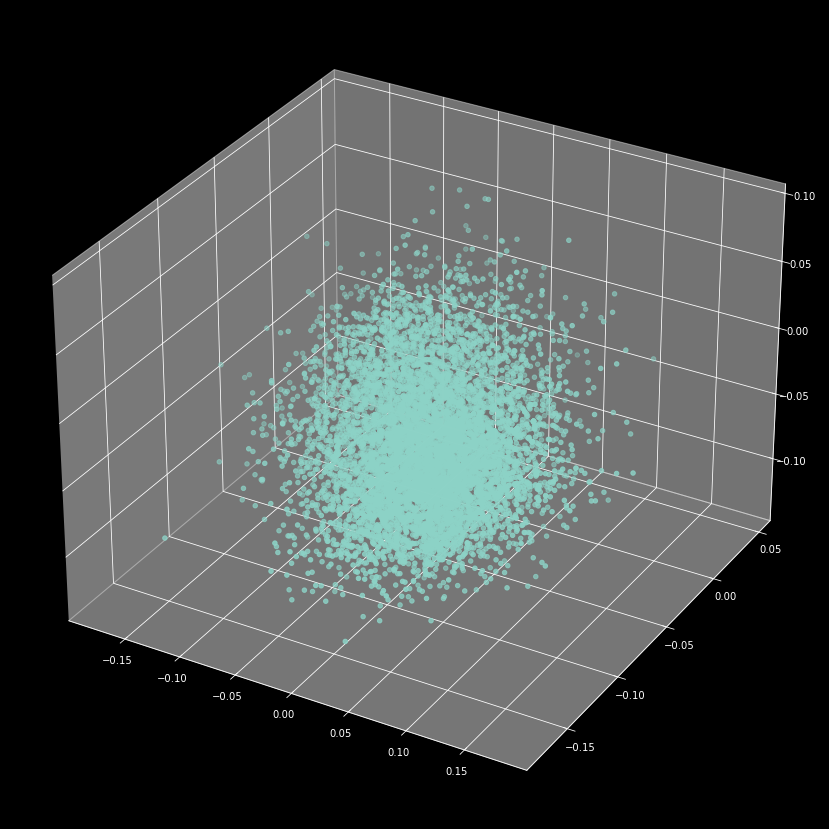

In [33]:
i = 0
j, k = i+1, i+2

x, y, z = embed_np[:, i], embed_np[:, j], embed_np[:, k]

label = raw_news['title']

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x, y, z)
plt.show()
#for n, txt in enumerate(label):
    #print("\r", f"n: {n}    txt: {txt}", end="")
    #plt.annotate(txt, (x[n], y[n]), backgroundcolor='black')

## PCA regression to see correlations

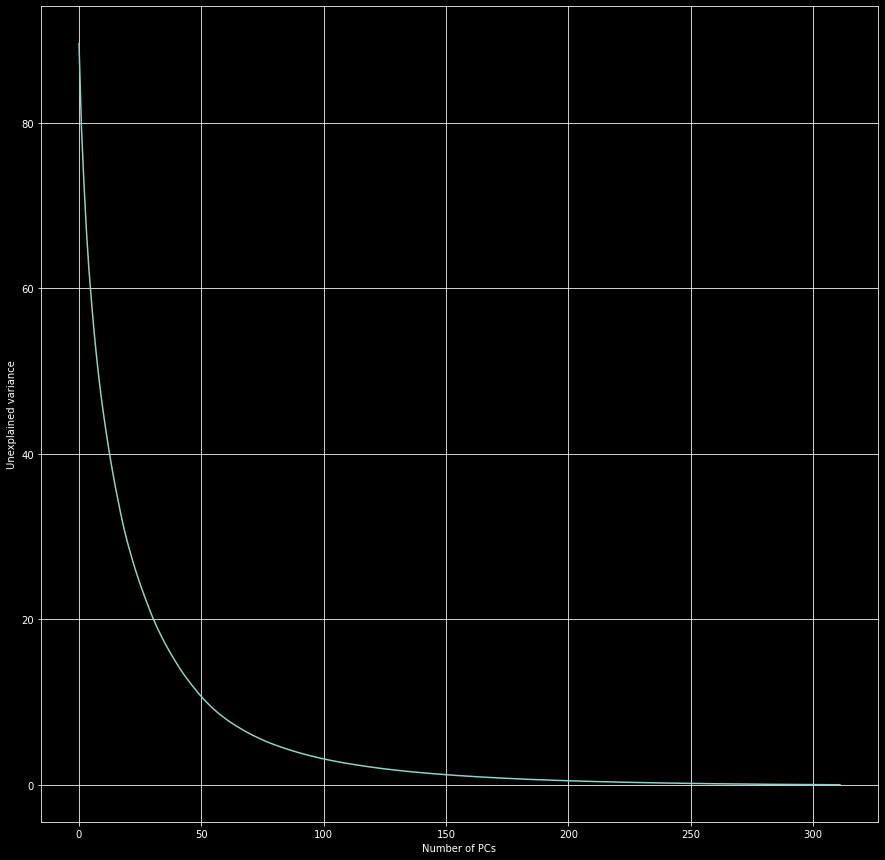

In [19]:
pca = PCA(n_components=cut_length)
pca.fit(embed_np)
exp_var = pca.explained_variance_ratio_ * 100
c_exp_var = [100 - sum(exp_var[:i+1]) for i in range(cut_length)]

plt.plot(c_exp_var)
plt.xlabel('Number of PCs')
plt.ylabel('Unexplained variance')
plt.grid()

In [20]:
n_comp = 10
pca_opt = PCA(n_components=n_comp)
pca_opt.fit(embed_np)
embed_opt = pca_opt.transform(embed_np)
print(f"Shape of transformed embedding: {embed_opt.shape}")

Shape of transformed embedding: (7629, 10)


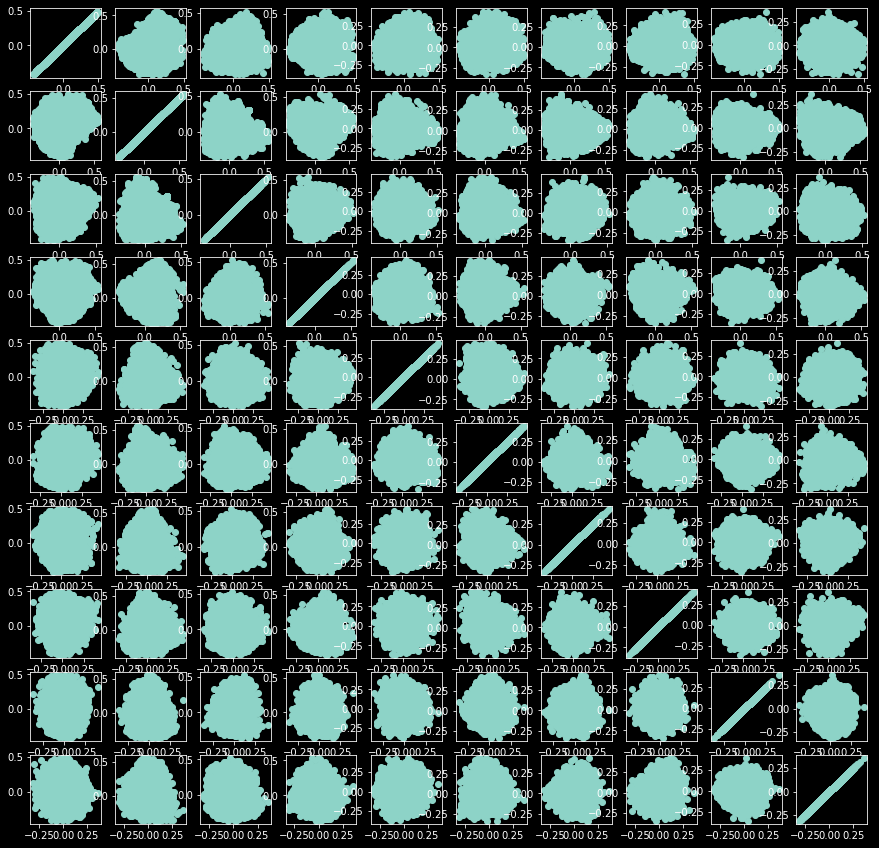

In [21]:
total_plot = 1
for i in range(n_comp):
    for j in range(n_comp):
        plt.subplot(n_comp, n_comp, total_plot)
        x, y = embed_opt[:, i], embed_opt[:, j]
        plt.scatter(x, y)
        total_plot += 1

## Check keyword prompts, calculate dot products for all dates

In [22]:
def keyword_in_news(keyword='футбол', embed_np=embed_np, dist='cos'):
    """Function to find keywords in news via dot product, [dist = cos or dot]."""
    ans_np = []
    for i in range(len(embed_np)):
        if dist == 'dot':
            ans = np.array(embed_bert_cls(keyword, model, tokenizer)).dot(embed_np[i])
        elif dist == 'cos':
            ans = 1 - spatial.distance.cosine(np.array(embed_bert_cls(keyword, model, tokenizer)), embed_np[i])
        ans_np.append(ans)
    return np.array(ans_np)

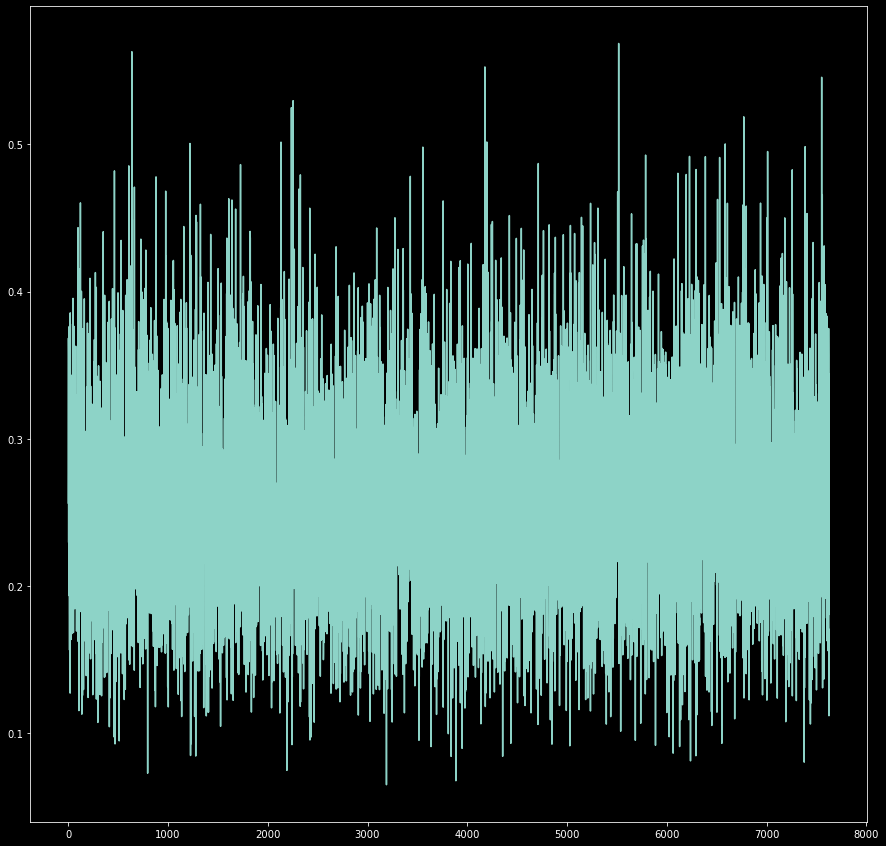

In [23]:
kwd = keyword_in_news('февраль')
plt.plot(kwd)

In [24]:
def items2days(keyword, news_dataframe=raw_news, divide_by_entries=False, dist='cos'):
    """Transforms keyword in news into time series."""
    ans_key = str(keyword)
    kwd_list = keyword_in_news(keyword, dist=dist)
    
    datify = lambda x: date(int(x[0:4]), int(x[5:7]), int(x[8:10]))
    zero2one = lambda x: 1 if x==0 else x

    num_days = max(news_dataframe['date']) - min(news_dataframe['date'])
    
    ans_list = np.zeros(num_days + 1)
    ans_divider = np.zeros(num_days + 1)
    
    assert len(news_dataframe) == len(kwd_list), f"len(news_dataframa) != len(kwd_list)"
    for i in range(len(news_dataframe)):
        lag = news_dataframe.iloc[i]['date']
        ans_list[lag] += kwd_list[i]
        ans_divider[lag] += 1
    
    if divide_by_entries:
        ans_divider = list(map(zero2one, ans_divider))
        ans_list = ans_list / ans_divider
    
    return ans_key, ans_list

In [25]:
word_list = ['новый год', 'февраль', 'россия', 'призыв', 'футбол', 'суббота', 'воскресенье', 'выходные']

In [26]:
if 'kwd_time_series' in globals():
    del kwd_time_series

kwd_time_series = pd.DataFrame()
kwd_time_series['date'] = list(range(num_days + 1))

activator = lambda x: 1 / (1-x) - 1

for word in word_list:
    kwd_time_series.insert(1, *items2days(word, raw_news, divide_by_entries=True), False)
    print(f"Word <<{word}>> inserted")
    kwd_time_series[word] = kwd_time_series[word].apply(activator)
    print("\t...and scaled.")

Word <<новый год>> inserted
	...and scaled.
Word <<февраль>> inserted
	...and scaled.
Word <<россия>> inserted
	...and scaled.
Word <<призыв>> inserted
	...and scaled.
Word <<футбол>> inserted
	...and scaled.
Word <<суббота>> inserted
	...and scaled.
Word <<воскресенье>> inserted
	...and scaled.
Word <<выходные>> inserted
	...and scaled.


In [27]:
kwd_time_series.head()

,date,выходные,воскресенье,суббота,футбол,призыв,россия,февраль,новый год
0,0,0.414987,0.431746,0.382594,0.365640,0.355851,0.739458,0.404713,0.606368
1,1,0.388944,0.396983,0.363511,0.344448,0.344926,0.632946,0.349542,0.524919
2,2,0.378185,0.425522,0.356264,0.356089,0.366407,0.650037,0.378609,0.582233
3,3,0.389698,0.429150,0.372178,0.346495,0.362711,0.651094,0.361306,0.528257
4,4,0.375624,0.396247,0.362852,0.345261,0.351200,0.645975,0.345249,0.526109


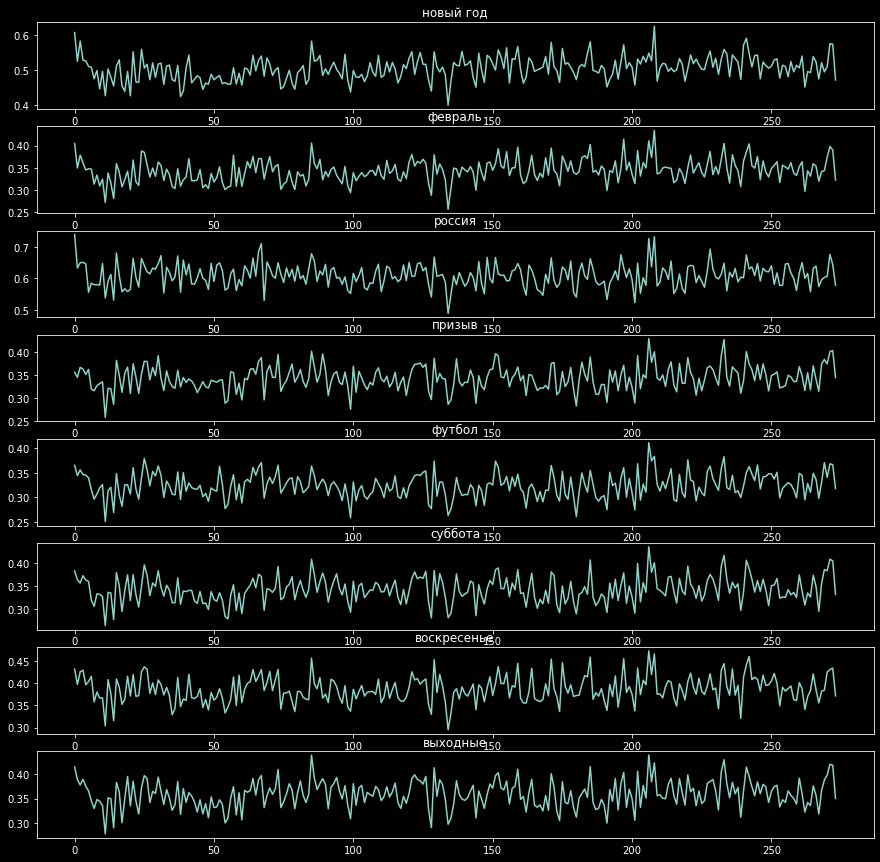

In [28]:
for num, word in enumerate(word_list):
    plt.subplot(len(word_list), 1, num+1)
    plt.plot(kwd_time_series[word])
    plt.title(word)

In [29]:
kwd_time_series['mean'] = kwd_time_series.drop('date', axis=1).mean(axis=1)
for word in word_list:
    kwd_time_series[word] -= kwd_time_series['mean']

In [30]:
kwd_time_series.head()

,date,выходные,воскресенье,суббота,футбол,призыв,россия,февраль,новый год,mean
0,0,-0.047682,-0.030923,-0.080076,-0.097029,-0.106819,0.276789,-0.057957,0.143699,0.462670
1,1,-0.029333,-0.021294,-0.054767,-0.073830,-0.073351,0.214669,-0.068736,0.106642,0.418277
2,2,-0.058483,-0.011146,-0.080405,-0.080579,-0.070261,0.213369,-0.058059,0.145565,0.436668
3,3,-0.040413,-0.000961,-0.057933,-0.083616,-0.067400,0.220983,-0.068806,0.098146,0.430111
4,4,-0.042940,-0.022318,-0.055713,-0.073304,-0.067364,0.227410,-0.073316,0.107545,0.418565


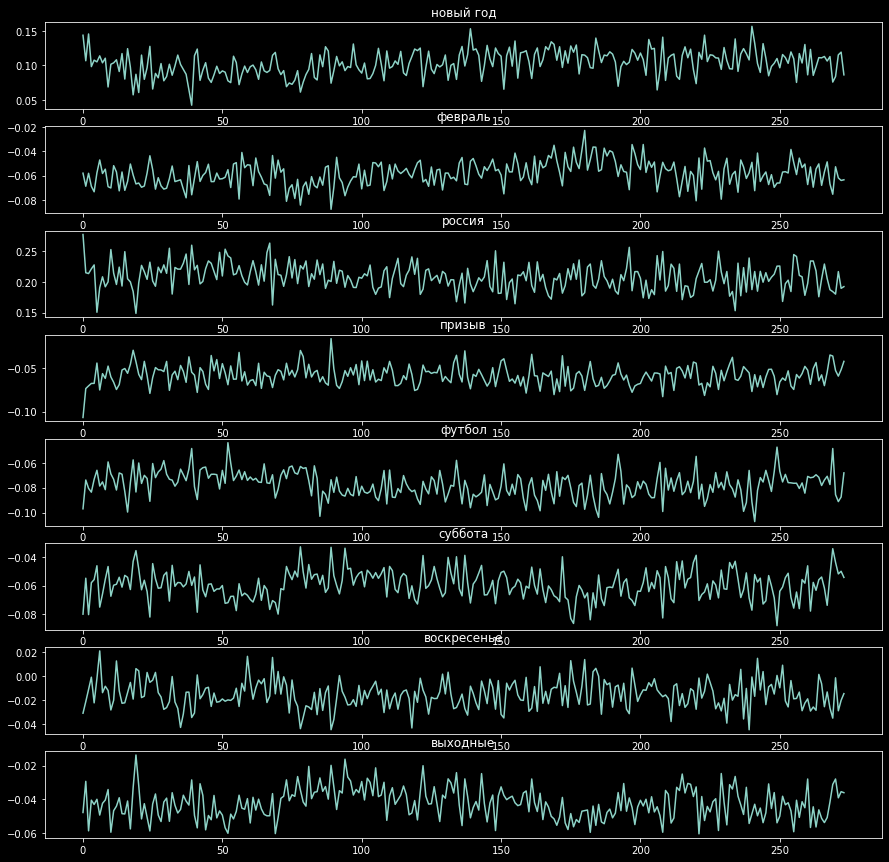

In [31]:
for num, word in enumerate(word_list):
    plt.subplot(len(word_list), 1, num+1)
    plt.plot(kwd_time_series[word])
    plt.title(word)

In [45]:
russia = np.array(embed_bert_cls('россия', model, tokenizer))
russian = np.array(embed_bert_cls('российский', model, tokenizer))
shop = np.array(embed_bert_cls('магазин', model, tokenizer))

print("                       no act.    act.")
print(f"russia * russian       {russia.dot(russian):.2f}       {activator(russia.dot(russian)):.2f}")
print(f"russia * shop          {russia.dot(shop):.2f}       {activator(russia.dot(shop)):.2f}")
print(f"russian * shop         {russian.dot(shop):.2f}       {activator(russian.dot(shop)):.2f}")

                       no act.    act.
russia * russian       0.95       19.41
russia * shop          0.85       5.54
russian * shop         0.84       5.17
